# Address-Aware GNN for Cryptographic Function Detection

This notebook provides a complete implementation of a Graph Neural Network for detecting cryptographic functions in binary code.

**Key Features:**
- Address-aware spatial features (novel)
- Multiple GNN architectures (GCN, GAT, SAGE, GIN)
- 100+ features per function
- End-to-end pipeline: Data → Training → Inference

**Notebook Structure:**
1. Setup & Imports
2. Address Feature Extraction
3. Data Loading & Preprocessing
4. GNN Model Architectures
5. Training Pipeline
6. Evaluation & Visualization
7. Inference Pipeline
8. Complete Training & Testing

---
## Part 1: Setup & Imports

In [1]:
# Core imports
import json
import glob
import os
import pickle
import warnings
from pathlib import Path
from collections import Counter, defaultdict
from typing import List, Dict, Tuple, Optional

# Data processing
import numpy as np
import pandas as pd

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns

# Progress bars
from tqdm.notebook import tqdm

# Machine Learning
from sklearn.model_selection import train_test_split
from sklearn.metrics import (
    classification_report, confusion_matrix,
    accuracy_score, f1_score, precision_recall_fscore_support
)
from sklearn.preprocessing import LabelEncoder, StandardScaler

# PyTorch
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, Dataset

# PyTorch Geometric
from torch_geometric.data import Data, Batch
from torch_geometric.nn import (
    GCNConv, GATConv, SAGEConv, GINConv,
    global_mean_pool, global_max_pool, global_add_pool,
    BatchNorm, GraphNorm
)

# Settings
warnings.filterwarnings('ignore')
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("husl")
%matplotlib inline

# Set random seeds for reproducibility
torch.manual_seed(42)
np.random.seed(42)

print("✓ All imports successful!")
print(f"PyTorch version: {torch.__version__}")
print(f"Device: {'GPU' if torch.cuda.is_available() else 'CPU'}")

✓ All imports successful!
PyTorch version: 2.9.1+cu128
Device: GPU


---
## Part 2: Address Feature Extraction

This section implements **novel address-aware features** that capture spatial patterns in binary code.

In [2]:
class AddressFeatureExtractor:
    """
    Extracts advanced address-based features from binary code.
    
    Address features capture spatial patterns, code locality, and
    memory layout information that's crucial for crypto detection.
    """
    
    @staticmethod
    def normalize_address(address: str) -> str:
        """
        Normalize address format to plain hex string.
        
        Handles formats:
        - "00010000" → "00010000"
        - "code:010000" → "010000"
        - "CODE:ABCDEF" → "ABCDEF"
        - "0x10000" → "10000"
        """
        # Handle code: prefix (case-insensitive)
        if address.lower().startswith('code:'):
            address = address[5:]
        # Handle 0x prefix
        if address.startswith('0x') or address.startswith('0X'):
            address = address[2:]
        return address
    
    @staticmethod
    def extract_address_features(address: str) -> Dict[str, float]:
        """
        Extract multiple features from a hexadecimal address.
        
        Returns 10 features:
        - Normalized value, alignment (4/8/16)
        - Section detection (text/data/bss)
        - Entropy, bit patterns
        """
        # Normalize address format
        address = AddressFeatureExtractor.normalize_address(address)
        addr_int = int(address, 16)
        
        features = {
            'addr_value_normalized': addr_int / 0xFFFFFFFF,
            'addr_alignment_4': float(addr_int % 4 == 0),
            'addr_alignment_8': float(addr_int % 8 == 0),
            'addr_alignment_16': float(addr_int % 16 == 0),
            
            'is_text_section': float(0x8000 <= addr_int < 0x100000),
            'is_data_section': float(0x100000 <= addr_int < 0x200000),
            'is_bss_section': float(0x200000 <= addr_int < 0x300000),
            
            'addr_entropy': AddressFeatureExtractor._calculate_hex_entropy(address),
            'addr_ones_ratio': bin(addr_int).count('1') / 32,
            'addr_nibble_variety': len(set(address)) / 16,
        }
        
        return features
    
    @staticmethod
    def _calculate_hex_entropy(hex_string: str) -> float:
        """Calculate Shannon entropy of hex string."""
        if not hex_string:
            return 0.0
        
        hex_string = AddressFeatureExtractor.normalize_address(hex_string)
        freq = Counter(hex_string)
        length = len(hex_string)
        
        entropy = -sum((count/length) * np.log2(count/length)
                      for count in freq.values() if count > 0)
        
        return entropy / 4.0 if length > 0 else 0.0
    
    @staticmethod
    def compute_edge_address_features(src_addr: str, dst_addr: str) -> Dict[str, float]:
        """
        Compute address-based features for control flow edges.
        
        Returns 9 features about jump distances and patterns.
        """
        # Normalize addresses
        src_addr = AddressFeatureExtractor.normalize_address(src_addr)
        dst_addr = AddressFeatureExtractor.normalize_address(dst_addr)
        
        src_int = int(src_addr, 16)
        dst_int = int(dst_addr, 16)
        
        jump_distance = dst_int - src_int
        abs_distance = abs(jump_distance)
        
        features = {
            'jump_distance': jump_distance,
            'abs_jump_distance': abs_distance,
            'jump_distance_log': np.log1p(abs_distance),
            
            'is_forward_jump': float(jump_distance > 0),
            'is_backward_jump': float(jump_distance < 0),
            'is_short_jump': float(abs_distance < 256),
            'is_long_jump': float(abs_distance > 4096),
            
            'alignment_preserved': float((src_int % 16) == (dst_int % 16)),
            'crosses_section': float(abs_distance > 0x10000),
        }
        
        return features
    
    @staticmethod
    def compute_graph_address_features(addresses: List[str]) -> Dict[str, float]:
        """
        Compute global address features for entire function graph.
        
        Returns 5 features about code layout and density.
        """
        if not addresses:
            return {f'graph_addr_{k}': 0.0 for k in [
                'span', 'span_log', 'density', 'avg_gap', 'locality_score'
            ]}
        
        # Normalize all addresses
        normalized_addresses = [AddressFeatureExtractor.normalize_address(addr) for addr in addresses]
        addr_ints = sorted([int(addr, 16) for addr in normalized_addresses])
        
        span = addr_ints[-1] - addr_ints[0] if len(addr_ints) > 1 else 0
        density = len(addr_ints) / (span + 1) if span > 0 else 1.0
        
        gaps = [addr_ints[i+1] - addr_ints[i] for i in range(len(addr_ints)-1)]
        avg_gap = np.mean(gaps) if gaps else 0
        locality_score = 1.0 / (1.0 + np.log1p(avg_gap))
        
        return {
            'graph_addr_span': span,
            'graph_addr_span_log': np.log1p(span),
            'graph_addr_density': density,
            'graph_addr_avg_gap': avg_gap,
            'graph_addr_locality_score': locality_score,
        }

print("✓ AddressFeatureExtractor defined")

# Test it
test_addr = "code:010000"
features = AddressFeatureExtractor.extract_address_features(test_addr)
print(f"\nTest: '{test_addr}' → {len(features)} features extracted")
for k, v in list(features.items())[:3]:
    print(f"  {k}: {v}")

✓ AddressFeatureExtractor defined

Test: 'code:010000' → 10 features extracted
  addr_value_normalized: 1.5258789066052714e-05
  addr_alignment_4: 1.0
  addr_alignment_8: 1.0


---
## Part 3: Dataset & Data Loading

Load Ghidra JSON files and convert to graph representations.

In [3]:
# Configuration
CONFIG = {
    'data_dir': '/home/bhoomi/Desktop/compilerRepo/vestigo-data/ghidra_json',
    'output_dir': './gnn_outputs',
    'model_dir': './gnn_models',
    
    # Model hyperparameters
    'hidden_dim': 256,
    'num_layers': 4,
    'dropout': 0.3,
    'conv_type': 'gat',  # 'gcn', 'gat', 'sage', 'gin'
    'pooling': 'concat',
    
    # Training hyperparameters
    'batch_size': 32,
    'num_epochs': 80,  # Reduced for notebook
    'lr': 0.001,
    'weight_decay': 1e-4,
    
    # Data split
    'train_ratio': 0.7,
    'val_ratio': 0.15,
    'test_ratio': 0.15,
}

# Create output directories
os.makedirs(CONFIG['output_dir'], exist_ok=True)
os.makedirs(CONFIG['model_dir'], exist_ok=True)

print("Configuration:")
for k, v in CONFIG.items():
    print(f"  {k}: {v}")

Configuration:
  data_dir: /home/bhoomi/Desktop/compilerRepo/vestigo-data/ghidra_json
  output_dir: ./gnn_outputs
  model_dir: ./gnn_models
  hidden_dim: 256
  num_layers: 4
  dropout: 0.3
  conv_type: gat
  pooling: concat
  batch_size: 32
  num_epochs: 80
  lr: 0.001
  weight_decay: 0.0001
  train_ratio: 0.7
  val_ratio: 0.15
  test_ratio: 0.15


In [4]:
# Load JSON files
json_files = glob.glob(os.path.join(CONFIG['data_dir'], '*.json'))
print(f"Found {len(json_files)} JSON files")

# Quick preview of a file
if json_files:
    print(f"\nSample file: {os.path.basename(json_files[0])}")
    with open(json_files[0], 'r') as f:
        sample_data = json.load(f)
    print(f"  Metadata: {sample_data.get('metadata', {})}")
    print(f"  Number of functions: {len(sample_data.get('functions', []))}")
    if sample_data.get('functions'):
        func = sample_data['functions'][0]
        print(f"  Sample function address: {func.get('address', 'N/A')}")
        print(f"  Sample function label: {func.get('label', 'N/A')}")

Found 334 JSON files

Sample file: wolfssl_ecc_x86_O3.o_features.json
  Metadata: {'data_size': 632, 'total_tables_detected': 1144, 'text_size': 37861, 'rodata_size': 2632, 'num_functions': 87}
  Number of functions: 87
  Sample function address: 00010000
  Sample function label: ECC


### Analyze Label Distribution

Analyzing dataset...


Loading files:   0%|          | 0/50 [00:00<?, ?it/s]


Total functions analyzed: 1548


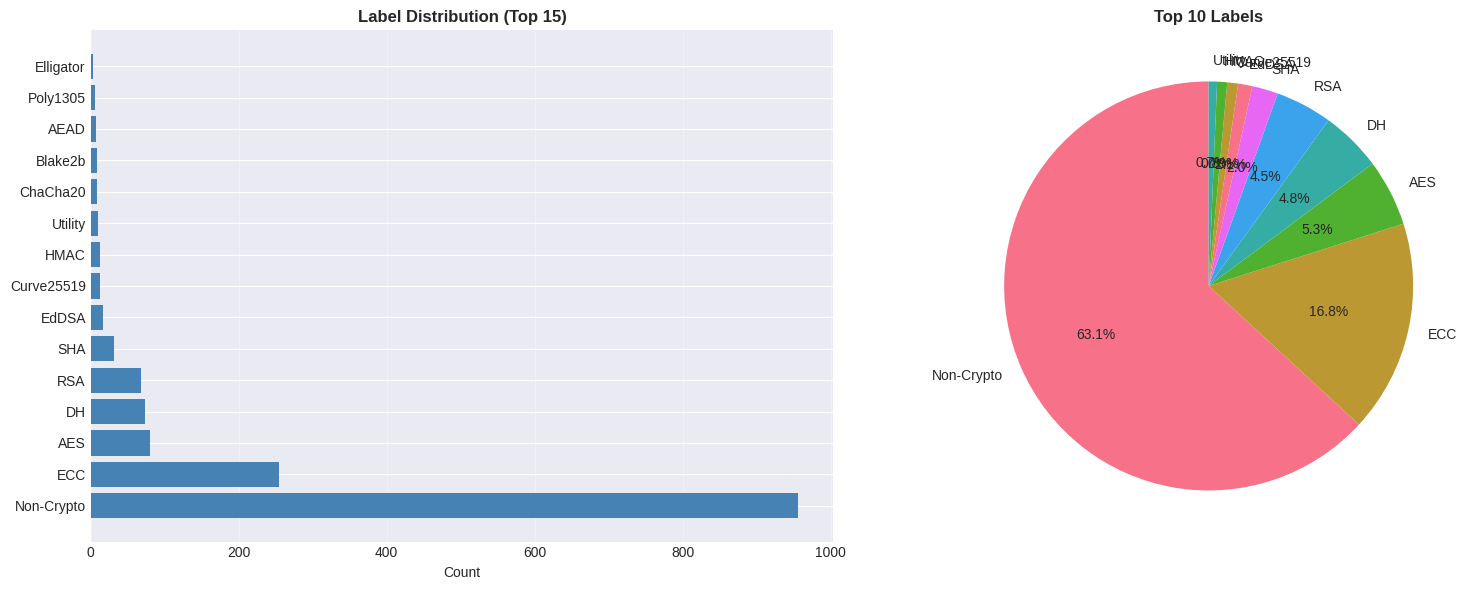


Label counts:
  Non-Crypto: 956
  ECC: 254
  AES: 80
  DH: 73
  RSA: 68
  SHA: 31
  EdDSA: 17
  Curve25519: 13
  HMAC: 12
  Utility: 10
  ChaCha20: 9
  Blake2b: 8
  AEAD: 7
  Poly1305: 6
  Elligator: 3
  KDF: 1


In [5]:
# Analyze label distribution
all_labels = []
all_complexities = []

print("Analyzing dataset...")
for json_file in tqdm(json_files[:50], desc="Loading files"):  # Sample for speed
    try:
        with open(json_file, 'r') as f:
            data = json.load(f)
        
        for func in data.get('functions', []):
            if 'label' in func:
                all_labels.append(func['label'])
                complexity = func.get('graph_level', {}).get('cyclomatic_complexity', 0)
                all_complexities.append(complexity)
    except Exception as e:
        print(f"Error loading {json_file}: {e}")
        continue

print(f"\nTotal functions analyzed: {len(all_labels)}")

# Plot distribution
label_counts = Counter(all_labels)
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Bar chart
labels, counts = zip(*label_counts.most_common(15))
axes[0].barh(range(len(labels)), counts, color='steelblue')
axes[0].set_yticks(range(len(labels)))
axes[0].set_yticklabels(labels)
axes[0].set_xlabel('Count')
axes[0].set_title('Label Distribution (Top 15)', fontweight='bold')
axes[0].grid(axis='x', alpha=0.3)

# Pie chart
top_10 = label_counts.most_common(10)
labels_pie, counts_pie = zip(*top_10)
axes[1].pie(counts_pie, labels=labels_pie, autopct='%1.1f%%', startangle=90)
axes[1].set_title('Top 10 Labels', fontweight='bold')

plt.tight_layout()
plt.savefig(os.path.join(CONFIG['output_dir'], 'label_distribution.png'), dpi=300, bbox_inches='tight')
plt.show()

print("\nLabel counts:")
for label, count in label_counts.most_common():
    print(f"  {label}: {count}")

---
## Part 4: Graph Dataset Implementation

Convert JSON functions to PyTorch Geometric graphs.

In [6]:
# This is a simplified version - full implementation in new_gnn.py
# For the notebook, we'll import from the main file

import sys
sys.path.insert(0, '/home/bhoomi/Desktop/compilerRepo/vestigo-data/ml')

from new_gnn import GraphDataset, collate_fn

print("✓ GraphDataset imported from new_gnn.py")
print("\nNote: Full GraphDataset implementation is in new_gnn.py")
print("It includes:")
print("  - JSON parsing")
print("  - Graph construction (nodes, edges)")
print("  - Feature extraction (100+ features)")
print("  - Feature scaling (StandardScaler)")
print("  - Label encoding")

✓ GraphDataset imported from new_gnn.py

Note: Full GraphDataset implementation is in new_gnn.py
It includes:
  - JSON parsing
  - Graph construction (nodes, edges)
  - Feature extraction (100+ features)
  - Feature scaling (StandardScaler)
  - Label encoding


### Load Training Data

In [7]:
# Split data
train_files, test_files = train_test_split(
    json_files,
    test_size=CONFIG['test_ratio'],
    random_state=42
)

train_files, val_files = train_test_split(
    train_files,
    test_size=CONFIG['val_ratio'] / (CONFIG['train_ratio'] + CONFIG['val_ratio']),
    random_state=42
)

print(f"Data split:")
print(f"  Train: {len(train_files)} files")
print(f"  Val: {len(val_files)} files")
print(f"  Test: {len(test_files)} files")

Data split:
  Train: 233 files
  Val: 50 files
  Test: 51 files


In [8]:
# Load datasets
print("Loading training dataset...")
train_dataset = GraphDataset(train_files)

print("\nLoading validation dataset...")
val_dataset = GraphDataset(val_files, train_dataset.label_encoder)
val_dataset.node_scaler = train_dataset.node_scaler
val_dataset.edge_scaler = train_dataset.edge_scaler
val_dataset.graph_scaler = train_dataset.graph_scaler

print("\nLoading test dataset...")
test_dataset = GraphDataset(test_files, train_dataset.label_encoder)
test_dataset.node_scaler = train_dataset.node_scaler
test_dataset.edge_scaler = train_dataset.edge_scaler
test_dataset.graph_scaler = train_dataset.graph_scaler

print(f"\n✓ Datasets loaded successfully!")
print(f"Classes: {train_dataset.label_encoder.classes_}")
print(f"\nDataset sizes:")
print(f"  Train: {len(train_dataset)} functions")
print(f"  Val: {len(val_dataset)} functions")
print(f"  Test: {len(test_dataset)} functions")

Loading training dataset...
Loading 233 JSON files...


Loading data: 100%|██████████| 233/233 [00:09<00:00, 24.29it/s]



Dataset loaded: 6852 functions
Label distribution:
  Non-Crypto: 3712
  ECC: 1641
  AES: 283
  RSA: 262
  DH: 172
  Curve25519: 138
  EdDSA: 135
  SHA: 96
  ChaCha20: 78
  HMAC: 72
  Blake2b: 68
  Utility: 61
  AEAD: 56
  Poly1305: 46
  Elligator: 24
  KDF: 8

Loading validation dataset...
Loading 50 JSON files...


Loading data: 100%|██████████| 50/50 [00:01<00:00, 39.24it/s]



Dataset loaded: 728 functions
Label distribution:
  ECC: 325
  RSA: 96
  AES: 71
  Non-Crypto: 64
  DH: 52
  ChaCha20: 22
  SHA: 21
  EdDSA: 16
  Utility: 13
  HMAC: 12
  Curve25519: 12
  Blake2b: 7
  AEAD: 7
  Poly1305: 6
  Elligator: 3
  KDF: 1

Loading test dataset...
Loading 51 JSON files...


Loading data: 100%|██████████| 51/51 [00:01<00:00, 50.62it/s]


Dataset loaded: 729 functions
Label distribution:
  ECC: 190
  AES: 79
  Non-Crypto: 75
  DH: 74
  SHA: 68
  EdDSA: 49
  Curve25519: 37
  RSA: 29
  Utility: 23
  Blake2b: 22
  AEAD: 21
  ChaCha20: 17
  Poly1305: 17
  HMAC: 16
  Elligator: 9
  KDF: 3

✓ Datasets loaded successfully!
Classes: ['AEAD' 'AES' 'Blake2b' 'ChaCha20' 'Curve25519' 'DH' 'ECC' 'EdDSA'
 'Elligator' 'HMAC' 'KDF' 'Non-Crypto' 'Poly1305' 'RSA' 'SHA' 'Utility']

Dataset sizes:
  Train: 6852 functions
  Val: 728 functions
  Test: 729 functions


In [ ]:
# Verify edge feature dimensions are correct
print("Verifying edge feature fix...")
print("-" * 60)

# Check the actual dimension used in new_gnn.py
test_graph = train_dataset.graphs[0]
edge_dim = test_graph['edge_features'].shape[1]

print(f"Edge feature dimension: {edge_dim}")

# Verify consistency across multiple graphs
edge_dims = set()
for i, graph in enumerate(train_dataset.graphs[:50]):
    edge_dims.add(graph['edge_features'].shape[1])

if len(edge_dims) == 1 and 13 in edge_dims:
    print(f"✓ All graphs have consistent edge feature dimension: {edge_dims}")
    print("✓ Edge feature fix is working correctly!")
else:
    print(f"Inconsistent edge dimensions: {edge_dims}")
    print("   You may need to restart the kernel and reload new_gnn.py")

print("-" * 60)

Verifying edge feature fix...
------------------------------------------------------------
Edge feature dimension: 13
✓ All graphs have consistent edge feature dimension: {13}
✓ Edge feature fix is working correctly!
------------------------------------------------------------


In [10]:
# Create data loaders
train_loader = DataLoader(
    train_dataset,
    batch_size=CONFIG['batch_size'],
    shuffle=True,
    collate_fn=collate_fn
)

val_loader = DataLoader(
    val_dataset,
    batch_size=CONFIG['batch_size'],
    shuffle=False,
    collate_fn=collate_fn
)

test_loader = DataLoader(
    test_dataset,
    batch_size=CONFIG['batch_size'],
    shuffle=False,
    collate_fn=collate_fn
)

print(f"Data loaders created:")
print(f"  Train batches: {len(train_loader)}")
print(f"  Val batches: {len(val_loader)}")
print(f"  Test batches: {len(test_loader)}")

# Check a sample batch
sample_batch = next(iter(train_loader))
print(f"\nSample batch:")
print(f"  Graphs: {sample_batch.num_graphs}")
print(f"  Total nodes: {sample_batch.x.shape[0]}")
print(f"  Node features: {sample_batch.x.shape[1]}")
print(f"  Edges: {sample_batch.edge_index.shape[1]}")
print(f"  Graph features: {sample_batch.graph_features.shape[-1]}")

Data loaders created:
  Train batches: 215
  Val batches: 23
  Test batches: 23

Sample batch:
  Graphs: 32
  Total nodes: 929
  Node features: 28
  Edges: 1190
  Graph features: 2176


---
## Part 5: GNN Model Architecture

Define the Address-Aware GNN model.

In [11]:
# Import model from new_gnn.py
from new_gnn import AddressAwareGNN, HierarchicalGNN

print("✓ GNN models imported")
print("\nAvailable architectures:")
print("  1. AddressAwareGNN - Main model (GCN/GAT/SAGE/GIN)")
print("  2. HierarchicalGNN - Alternative with attention pooling")

✓ GNN models imported

Available architectures:
  1. AddressAwareGNN - Main model (GCN/GAT/SAGE/GIN)
  2. HierarchicalGNN - Alternative with attention pooling


In [12]:
# Get feature dimensions
sample = train_dataset[0]
num_node_features = sample.x.shape[1]
num_edge_features = sample.edge_attr.shape[1] if sample.edge_attr.numel() > 0 else 0
num_graph_features = sample.graph_features.shape[0]
num_classes = len(train_dataset.label_encoder.classes_)

print(f"Feature dimensions:")
print(f"  Node features: {num_node_features}")
print(f"  Edge features: {num_edge_features}")
print(f"  Graph features: {num_graph_features}")
print(f"  Number of classes: {num_classes}")

# Build model
model = AddressAwareGNN(
    num_node_features=num_node_features,
    num_edge_features=num_edge_features,
    num_graph_features=num_graph_features,
    num_classes=num_classes,
    hidden_dim=CONFIG['hidden_dim'],
    num_layers=CONFIG['num_layers'],
    dropout=CONFIG['dropout'],
    conv_type=CONFIG['conv_type'],
    pooling=CONFIG['pooling'],
)

total_params = sum(p.numel() for p in model.parameters())
trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)

print(f"\n✓ Model built: {CONFIG['conv_type'].upper()}")
print(f"  Total parameters: {total_params:,}")
print(f"  Trainable parameters: {trainable_params:,}")
print(f"\nModel summary:")
print(model)

Feature dimensions:
  Node features: 28
  Edge features: 13
  Graph features: 68
  Number of classes: 16

✓ Model built: GAT
  Total parameters: 842,512
  Trainable parameters: 842,512

Model summary:
AddressAwareGNN(
  (node_encoder): Sequential(
    (0): Linear(in_features=28, out_features=256, bias=True)
    (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Dropout(p=0.3, inplace=False)
  )
  (edge_encoder): Sequential(
    (0): Linear(in_features=13, out_features=128, bias=True)
    (1): ReLU()
  )
  (convs): ModuleList(
    (0-3): 4 x GATConv(256, 32, heads=8)
  )
  (batch_norms): ModuleList(
    (0-3): 4 x BatchNorm(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (classifier): Sequential(
    (0): Linear(in_features=836, out_features=512, bias=True)
    (1): BatchNorm1d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Dropout(p=0.3, inplace=False)
 

---
## Part 6: Training Pipeline

In [ ]:
# Import trainer
from new_gnn import GNNTrainer

# Auto-detect device (GPU if available, CPU otherwise)
import torch
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print("="*60)
print(f"Using device: {device.upper()}")
if device == 'cuda':
    print(f"   GPU: {torch.cuda.get_device_name(0)}")
    print(f"   Memory: {torch.cuda.get_device_properties(0).total_memory / 1e9:.2f} GB")
    print("   Expected training time: ~30-45 minutes")
else:
    print("   Expected training time: ~2-3 hours")
print("="*60)
print()

# Create trainer (auto-selects device)
trainer = GNNTrainer(
    model=model,
    train_loader=train_loader,
    val_loader=val_loader,
    test_loader=test_loader,
    label_encoder=train_dataset.label_encoder,
    device=device,  # Auto-detected device
    lr=CONFIG['lr'],
    weight_decay=CONFIG['weight_decay']
)

print("✓ Trainer created")
print(f"  Device: {trainer.device}")
print(f"  Optimizer: AdamW")
print(f"  Learning rate: {CONFIG['lr']}")
print(f"  Weight decay: {CONFIG['weight_decay']}")

🚀 Using device: CUDA
   GPU: NVIDIA GeForce RTX 4050 Laptop GPU
   Memory: 6.04 GB
   Expected training time: ~30-45 minutes

✓ Trainer created
  Device: cuda
  Optimizer: AdamW
  Learning rate: 0.001
  Weight decay: 0.0001


### Train the Model

In [14]:
# Train the model
print(f"Starting training for {CONFIG['num_epochs']} epochs...\n")

trainer.train(
    num_epochs=CONFIG['num_epochs'],
    save_dir=CONFIG['model_dir']
)

print("\n✓ Training complete!")

Starting training for 80 epochs...


Training on device: cuda
Number of parameters: 842,512

Epoch 1/80
--------------------------------------------------


Train Loss: 1.1147 | Train Acc: 0.7049
Val Loss: 2.0181 | Val Acc: 0.4258 | Val F1: 0.2963
✓ Saved best model (F1: 0.2963)

Epoch 2/80
--------------------------------------------------


Train Loss: 0.9412 | Train Acc: 0.7341
Val Loss: 1.9995 | Val Acc: 0.4547 | Val F1: 0.3085
✓ Saved best model (F1: 0.3085)

Epoch 3/80
--------------------------------------------------


Train Loss: 0.8990 | Train Acc: 0.7303
Val Loss: 1.9094 | Val Acc: 0.4766 | Val F1: 0.3636
✓ Saved best model (F1: 0.3636)

Epoch 4/80
--------------------------------------------------


Train Loss: 0.8618 | Train Acc: 0.7353
Val Loss: 1.9792 | Val Acc: 0.4766 | Val F1: 0.3397

Epoch 5/80
--------------------------------------------------


Train Loss: 0.8456 | Train Acc: 0.7427
Val Loss: 1.7491 | Val Acc: 0.4766 | Val F1: 0.3442

Epoch 6/80
--------------------------------------------------


Train Loss: 0.8231 | Train Acc: 0.7445
Val Loss: 1.9176 | Val Acc: 0.4629 | Val F1: 0.3549

Epoch 7/80
--------------------------------------------------


Train Loss: 0.8118 | Train Acc: 0.7494
Val Loss: 1.8753 | Val Acc: 0.4753 | Val F1: 0.3590

Epoch 8/80
--------------------------------------------------


Train Loss: 0.7955 | Train Acc: 0.7504
Val Loss: 1.8262 | Val Acc: 0.4698 | Val F1: 0.3561

Epoch 9/80
--------------------------------------------------


Train Loss: 0.7711 | Train Acc: 0.7496
Val Loss: 2.0034 | Val Acc: 0.4904 | Val F1: 0.3928
✓ Saved best model (F1: 0.3928)

Epoch 10/80
--------------------------------------------------


Train Loss: 0.7648 | Train Acc: 0.7561
Val Loss: 2.0563 | Val Acc: 0.4382 | Val F1: 0.3515

Epoch 11/80
--------------------------------------------------


Train Loss: 0.7522 | Train Acc: 0.7580
Val Loss: 1.9838 | Val Acc: 0.4080 | Val F1: 0.3519

Epoch 12/80
--------------------------------------------------


Train Loss: 0.7403 | Train Acc: 0.7636
Val Loss: 1.7826 | Val Acc: 0.4739 | Val F1: 0.3821

Epoch 13/80
--------------------------------------------------


Train Loss: 0.7346 | Train Acc: 0.7596
Val Loss: 1.8116 | Val Acc: 0.4670 | Val F1: 0.3768

Epoch 14/80
--------------------------------------------------


Train Loss: 0.7150 | Train Acc: 0.7672
Val Loss: 1.7848 | Val Acc: 0.4519 | Val F1: 0.3555

Epoch 15/80
--------------------------------------------------


Train Loss: 0.7162 | Train Acc: 0.7682
Val Loss: 1.7936 | Val Acc: 0.4698 | Val F1: 0.3947
✓ Saved best model (F1: 0.3947)

Epoch 16/80
--------------------------------------------------


Train Loss: 0.6933 | Train Acc: 0.7694
Val Loss: 1.7890 | Val Acc: 0.4437 | Val F1: 0.3710

Epoch 17/80
--------------------------------------------------


Train Loss: 0.6896 | Train Acc: 0.7720
Val Loss: 1.8411 | Val Acc: 0.4712 | Val F1: 0.4010
✓ Saved best model (F1: 0.4010)

Epoch 18/80
--------------------------------------------------


Train Loss: 0.6799 | Train Acc: 0.7767
Val Loss: 1.7360 | Val Acc: 0.4602 | Val F1: 0.3934

Epoch 19/80
--------------------------------------------------


Train Loss: 0.6621 | Train Acc: 0.7785
Val Loss: 1.8311 | Val Acc: 0.4602 | Val F1: 0.3843

Epoch 20/80
--------------------------------------------------


Train Loss: 0.6522 | Train Acc: 0.7842
Val Loss: 1.9660 | Val Acc: 0.4560 | Val F1: 0.3864

Epoch 21/80
--------------------------------------------------


Train Loss: 0.6509 | Train Acc: 0.7830
Val Loss: 1.8926 | Val Acc: 0.5082 | Val F1: 0.4455
✓ Saved best model (F1: 0.4455)

Epoch 22/80
--------------------------------------------------


Train Loss: 0.6317 | Train Acc: 0.7869
Val Loss: 1.8542 | Val Acc: 0.5206 | Val F1: 0.4477
✓ Saved best model (F1: 0.4477)

Epoch 23/80
--------------------------------------------------


Train Loss: 0.6260 | Train Acc: 0.7909
Val Loss: 2.0715 | Val Acc: 0.4396 | Val F1: 0.3772

Epoch 24/80
--------------------------------------------------


Train Loss: 0.6193 | Train Acc: 0.7909
Val Loss: 2.6380 | Val Acc: 0.5179 | Val F1: 0.4424

Epoch 25/80
--------------------------------------------------


Train Loss: 0.5999 | Train Acc: 0.7987
Val Loss: 1.7978 | Val Acc: 0.4863 | Val F1: 0.4198

Epoch 26/80
--------------------------------------------------


Train Loss: 0.5950 | Train Acc: 0.8022
Val Loss: 1.8856 | Val Acc: 0.4643 | Val F1: 0.3988

Epoch 27/80
--------------------------------------------------


Train Loss: 0.5846 | Train Acc: 0.8043
Val Loss: 1.9073 | Val Acc: 0.4890 | Val F1: 0.4425

Epoch 28/80
--------------------------------------------------


Train Loss: 0.5750 | Train Acc: 0.8030
Val Loss: 2.0474 | Val Acc: 0.3846 | Val F1: 0.3738

Epoch 29/80
--------------------------------------------------


Train Loss: 0.5683 | Train Acc: 0.8094
Val Loss: 1.9086 | Val Acc: 0.4986 | Val F1: 0.4297

Epoch 30/80
--------------------------------------------------


Train Loss: 0.5624 | Train Acc: 0.8112
Val Loss: 1.9694 | Val Acc: 0.4821 | Val F1: 0.4209

Epoch 31/80
--------------------------------------------------


Train Loss: 0.5548 | Train Acc: 0.8097
Val Loss: 1.7774 | Val Acc: 0.4739 | Val F1: 0.4401

Epoch 32/80
--------------------------------------------------


Train Loss: 0.5492 | Train Acc: 0.8142
Val Loss: 1.8240 | Val Acc: 0.4739 | Val F1: 0.4464

Epoch 33/80
--------------------------------------------------


Train Loss: 0.5449 | Train Acc: 0.8187
Val Loss: 1.7638 | Val Acc: 0.5055 | Val F1: 0.4529
✓ Saved best model (F1: 0.4529)

Epoch 34/80
--------------------------------------------------


Train Loss: 0.5417 | Train Acc: 0.8148
Val Loss: 1.8203 | Val Acc: 0.4973 | Val F1: 0.4329

Epoch 35/80
--------------------------------------------------


Train Loss: 0.5236 | Train Acc: 0.8231
Val Loss: 1.7946 | Val Acc: 0.5151 | Val F1: 0.4627
✓ Saved best model (F1: 0.4627)

Epoch 36/80
--------------------------------------------------


Train Loss: 0.5197 | Train Acc: 0.8221
Val Loss: 1.8131 | Val Acc: 0.5069 | Val F1: 0.4582

Epoch 37/80
--------------------------------------------------


Train Loss: 0.5053 | Train Acc: 0.8284
Val Loss: 1.7055 | Val Acc: 0.5261 | Val F1: 0.4721
✓ Saved best model (F1: 0.4721)

Epoch 38/80
--------------------------------------------------


Train Loss: 0.5054 | Train Acc: 0.8295
Val Loss: 1.8086 | Val Acc: 0.4670 | Val F1: 0.4185

Epoch 39/80
--------------------------------------------------


Train Loss: 0.4870 | Train Acc: 0.8371
Val Loss: 1.8891 | Val Acc: 0.4464 | Val F1: 0.3946

Epoch 40/80
--------------------------------------------------


Train Loss: 0.4884 | Train Acc: 0.8332
Val Loss: 1.8650 | Val Acc: 0.5220 | Val F1: 0.4696

Epoch 41/80
--------------------------------------------------


Train Loss: 0.4889 | Train Acc: 0.8281
Val Loss: 1.7591 | Val Acc: 0.5330 | Val F1: 0.4819
✓ Saved best model (F1: 0.4819)

Epoch 42/80
--------------------------------------------------


Train Loss: 0.4747 | Train Acc: 0.8339
Val Loss: 2.0361 | Val Acc: 0.5467 | Val F1: 0.5295
✓ Saved best model (F1: 0.5295)

Epoch 43/80
--------------------------------------------------


Train Loss: 0.4648 | Train Acc: 0.8383
Val Loss: 2.1132 | Val Acc: 0.5481 | Val F1: 0.4934

Epoch 44/80
--------------------------------------------------


Train Loss: 0.4691 | Train Acc: 0.8349
Val Loss: 2.0465 | Val Acc: 0.4931 | Val F1: 0.4271

Epoch 45/80
--------------------------------------------------


Train Loss: 0.4573 | Train Acc: 0.8411
Val Loss: 1.9462 | Val Acc: 0.5124 | Val F1: 0.4567

Epoch 46/80
--------------------------------------------------


Train Loss: 0.4491 | Train Acc: 0.8460
Val Loss: 1.7402 | Val Acc: 0.5357 | Val F1: 0.5027

Epoch 47/80
--------------------------------------------------


Train Loss: 0.4467 | Train Acc: 0.8443
Val Loss: 2.0861 | Val Acc: 0.5137 | Val F1: 0.4663

Epoch 48/80
--------------------------------------------------


Train Loss: 0.4428 | Train Acc: 0.8492
Val Loss: 1.9537 | Val Acc: 0.4904 | Val F1: 0.4679

Epoch 49/80
--------------------------------------------------


Train Loss: 0.4313 | Train Acc: 0.8476
Val Loss: 1.8717 | Val Acc: 0.5412 | Val F1: 0.4881

Epoch 50/80
--------------------------------------------------


Train Loss: 0.4267 | Train Acc: 0.8565
Val Loss: 1.9476 | Val Acc: 0.5330 | Val F1: 0.5177

Epoch 51/80
--------------------------------------------------


Train Loss: 0.4290 | Train Acc: 0.8484
Val Loss: 2.0909 | Val Acc: 0.5000 | Val F1: 0.4769

Epoch 52/80
--------------------------------------------------


Train Loss: 0.4243 | Train Acc: 0.8570
Val Loss: 2.3949 | Val Acc: 0.5371 | Val F1: 0.5186

Epoch 53/80
--------------------------------------------------


Train Loss: 0.4112 | Train Acc: 0.8581
Val Loss: 2.2588 | Val Acc: 0.5604 | Val F1: 0.5142

Epoch 54/80
--------------------------------------------------


Train Loss: 0.3816 | Train Acc: 0.8614
Val Loss: 1.9179 | Val Acc: 0.5385 | Val F1: 0.5147

Epoch 55/80
--------------------------------------------------


Train Loss: 0.3646 | Train Acc: 0.8735
Val Loss: 1.9954 | Val Acc: 0.5646 | Val F1: 0.5347
✓ Saved best model (F1: 0.5347)

Epoch 56/80
--------------------------------------------------


Train Loss: 0.3563 | Train Acc: 0.8754
Val Loss: 2.2292 | Val Acc: 0.5247 | Val F1: 0.4907

Epoch 57/80
--------------------------------------------------


Train Loss: 0.3454 | Train Acc: 0.8773
Val Loss: 1.9587 | Val Acc: 0.5618 | Val F1: 0.5438
✓ Saved best model (F1: 0.5438)

Epoch 58/80
--------------------------------------------------


Train Loss: 0.3501 | Train Acc: 0.8776
Val Loss: 1.9931 | Val Acc: 0.5632 | Val F1: 0.5228

Epoch 59/80
--------------------------------------------------


Train Loss: 0.3452 | Train Acc: 0.8786
Val Loss: 2.2680 | Val Acc: 0.5206 | Val F1: 0.4898

Epoch 60/80
--------------------------------------------------


Train Loss: 0.3520 | Train Acc: 0.8821
Val Loss: 1.9597 | Val Acc: 0.5412 | Val F1: 0.5014

Epoch 61/80
--------------------------------------------------


Train Loss: 0.3395 | Train Acc: 0.8792
Val Loss: 1.9944 | Val Acc: 0.5371 | Val F1: 0.4984

Epoch 62/80
--------------------------------------------------


Train Loss: 0.3307 | Train Acc: 0.8815
Val Loss: 2.0585 | Val Acc: 0.5549 | Val F1: 0.5170

Epoch 63/80
--------------------------------------------------


Train Loss: 0.3322 | Train Acc: 0.8824
Val Loss: 2.3685 | Val Acc: 0.5412 | Val F1: 0.5131

Epoch 64/80
--------------------------------------------------


Train Loss: 0.3217 | Train Acc: 0.8859
Val Loss: 2.1449 | Val Acc: 0.5343 | Val F1: 0.5142

Epoch 65/80
--------------------------------------------------


Train Loss: 0.3225 | Train Acc: 0.8897
Val Loss: 2.4956 | Val Acc: 0.4973 | Val F1: 0.4580

Epoch 66/80
--------------------------------------------------


Train Loss: 0.3166 | Train Acc: 0.8867
Val Loss: 1.9792 | Val Acc: 0.5508 | Val F1: 0.5105

Epoch 67/80
--------------------------------------------------


Train Loss: 0.3086 | Train Acc: 0.8885
Val Loss: 2.0991 | Val Acc: 0.5728 | Val F1: 0.5551
✓ Saved best model (F1: 0.5551)

Epoch 68/80
--------------------------------------------------


Train Loss: 0.3124 | Train Acc: 0.8872
Val Loss: 2.4186 | Val Acc: 0.5288 | Val F1: 0.5156

Epoch 69/80
--------------------------------------------------


Train Loss: 0.3147 | Train Acc: 0.8885
Val Loss: 2.1453 | Val Acc: 0.5618 | Val F1: 0.5421

Epoch 70/80
--------------------------------------------------


Train Loss: 0.3098 | Train Acc: 0.8929
Val Loss: 2.3271 | Val Acc: 0.5041 | Val F1: 0.4814

Epoch 71/80
--------------------------------------------------


Train Loss: 0.3089 | Train Acc: 0.8923
Val Loss: 2.1369 | Val Acc: 0.5618 | Val F1: 0.5432

Epoch 72/80
--------------------------------------------------


Train Loss: 0.3032 | Train Acc: 0.8952
Val Loss: 2.0433 | Val Acc: 0.5673 | Val F1: 0.5524

Epoch 73/80
--------------------------------------------------


Train Loss: 0.3077 | Train Acc: 0.8917
Val Loss: 2.1134 | Val Acc: 0.5618 | Val F1: 0.5469

Epoch 74/80
--------------------------------------------------


Train Loss: 0.2954 | Train Acc: 0.8938
Val Loss: 1.9273 | Val Acc: 0.5755 | Val F1: 0.5701
✓ Saved best model (F1: 0.5701)

Epoch 75/80
--------------------------------------------------


Train Loss: 0.2862 | Train Acc: 0.8954
Val Loss: 2.4034 | Val Acc: 0.5632 | Val F1: 0.5411

Epoch 76/80
--------------------------------------------------


Train Loss: 0.3107 | Train Acc: 0.8932
Val Loss: 2.4510 | Val Acc: 0.5110 | Val F1: 0.4811

Epoch 77/80
--------------------------------------------------


Train Loss: 0.2975 | Train Acc: 0.8946
Val Loss: 2.1051 | Val Acc: 0.5481 | Val F1: 0.5353

Epoch 78/80
--------------------------------------------------


Train Loss: 0.2866 | Train Acc: 0.8967
Val Loss: 2.4018 | Val Acc: 0.5096 | Val F1: 0.4944

Epoch 79/80
--------------------------------------------------


Train Loss: 0.2727 | Train Acc: 0.9025
Val Loss: 2.4382 | Val Acc: 0.5440 | Val F1: 0.5413

Epoch 80/80
--------------------------------------------------


Train Loss: 0.2860 | Train Acc: 0.8992
Val Loss: 2.5585 | Val Acc: 0.5069 | Val F1: 0.4892

Training completed! Best Val F1: 0.5701

✓ Training complete!


### Visualize Training History


✓ Saved training history plot: ./gnn_outputs/training_history.png


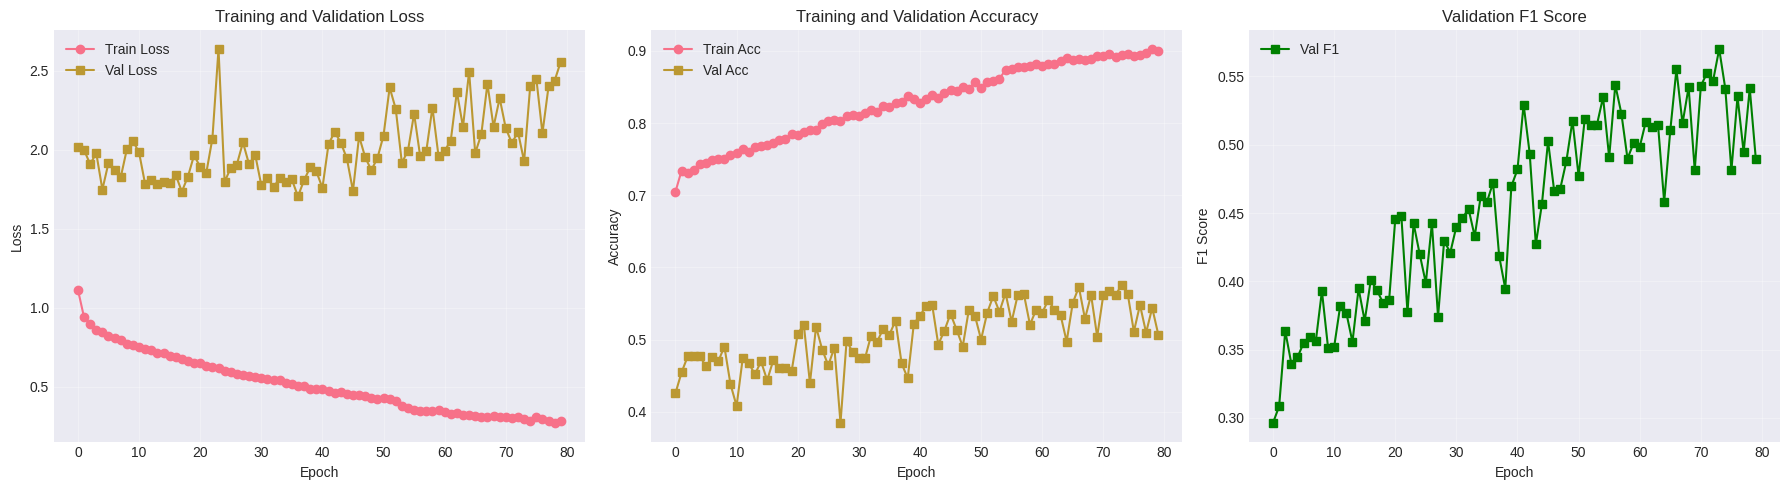

In [15]:
# Plot training curves
trainer.plot_training_history(
    save_path=os.path.join(CONFIG['output_dir'], 'training_history.png')
)

---
## Part 7: Evaluation & Testing

In [16]:
# Load best model
best_checkpoint = torch.load(
    os.path.join(CONFIG['model_dir'], 'best_model.pth'),
    map_location=trainer.device
)
trainer.model.load_state_dict(best_checkpoint['model_state_dict'])


print(f"✓ Loaded best model from epoch {best_checkpoint['epoch']}")

print(f"  Best Val F1: {best_checkpoint['val_f1']:.4f}")

✓ Loaded best model from epoch 73
  Best Val F1: 0.5701


In [17]:
# Test the model
test_results = trainer.test()

print("\n" + "="*60)
print("TEST SET RESULTS")
print("="*60)
print(f"Test Accuracy: {test_results['test_acc']:.4f}")
print(f"Test F1 Score: {test_results['test_f1']:.4f}")


TESTING ON HELD-OUT TEST SET

Test Loss: 1.8301
Test Accuracy: 0.5267
Test F1 (weighted): 0.5055

CLASSIFICATION REPORT
              precision    recall  f1-score   support

        AEAD     0.3548    0.5238    0.4231        21
         AES     0.5926    0.2025    0.3019        79
     Blake2b     0.5000    0.6364    0.5600        22
    ChaCha20     0.3333    0.1176    0.1739        17
  Curve25519     0.8333    0.4054    0.5455        37
          DH     0.7407    0.5405    0.6250        74
         ECC     0.5193    0.7789    0.6232       190
       EdDSA     0.3636    0.1633    0.2254        49
   Elligator     0.7500    0.3333    0.4615         9
        HMAC     0.4286    0.5625    0.4865        16
         KDF     0.6667    0.6667    0.6667         3
  Non-Crypto     0.4426    0.7200    0.5482        75
    Poly1305     0.1875    0.1765    0.1818        17
         RSA     0.8000    0.6897    0.7407        29
         SHA     0.5490    0.4118    0.4706        68
     Utility  

✓ Saved confusion matrix: ./gnn_outputs/confusion_matrix.png


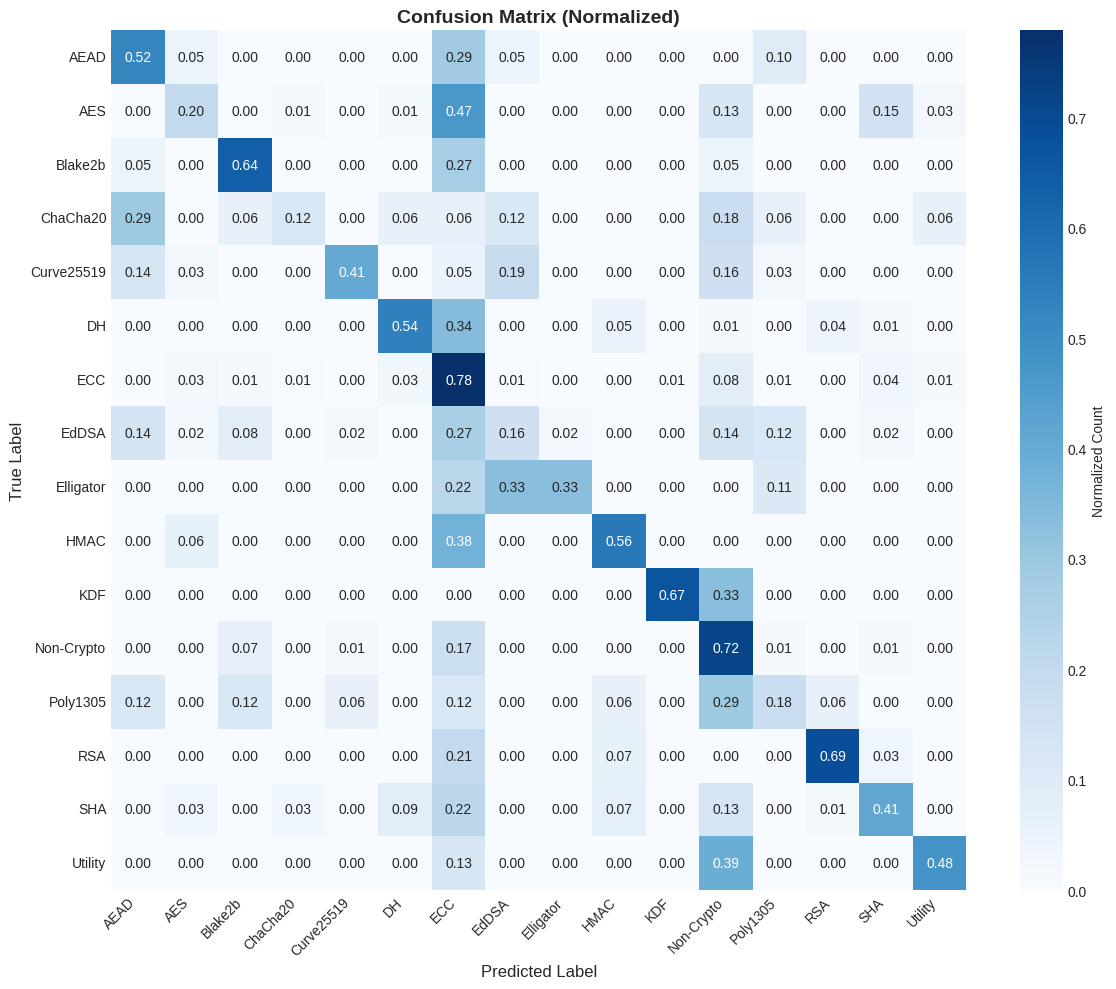

In [18]:
# Plot confusion matrix
trainer.plot_confusion_matrix(
    test_results['confusion_matrix'],
    save_path=os.path.join(CONFIG['output_dir'], 'confusion_matrix.png')
)

### Per-Class Performance Analysis


Per-class performance:
     Class  Precision   Recall  F1-Score  Support
       RSA   0.800000 0.689655  0.740741       29
       KDF   0.666667 0.666667  0.666667        3
        DH   0.740741 0.540541  0.625000       74
       ECC   0.519298 0.778947  0.623158      190
   Utility   0.687500 0.478261  0.564103       23
   Blake2b   0.500000 0.636364  0.560000       22
Non-Crypto   0.442623 0.720000  0.548223       75
Curve25519   0.833333 0.405405  0.545455       37
      HMAC   0.428571 0.562500  0.486486       16
       SHA   0.549020 0.411765  0.470588       68
 Elligator   0.750000 0.333333  0.461538        9
      AEAD   0.354839 0.523810  0.423077       21
       AES   0.592593 0.202532  0.301887       79
     EdDSA   0.363636 0.163265  0.225352       49
  Poly1305   0.187500 0.176471  0.181818       17
  ChaCha20   0.333333 0.117647  0.173913       17


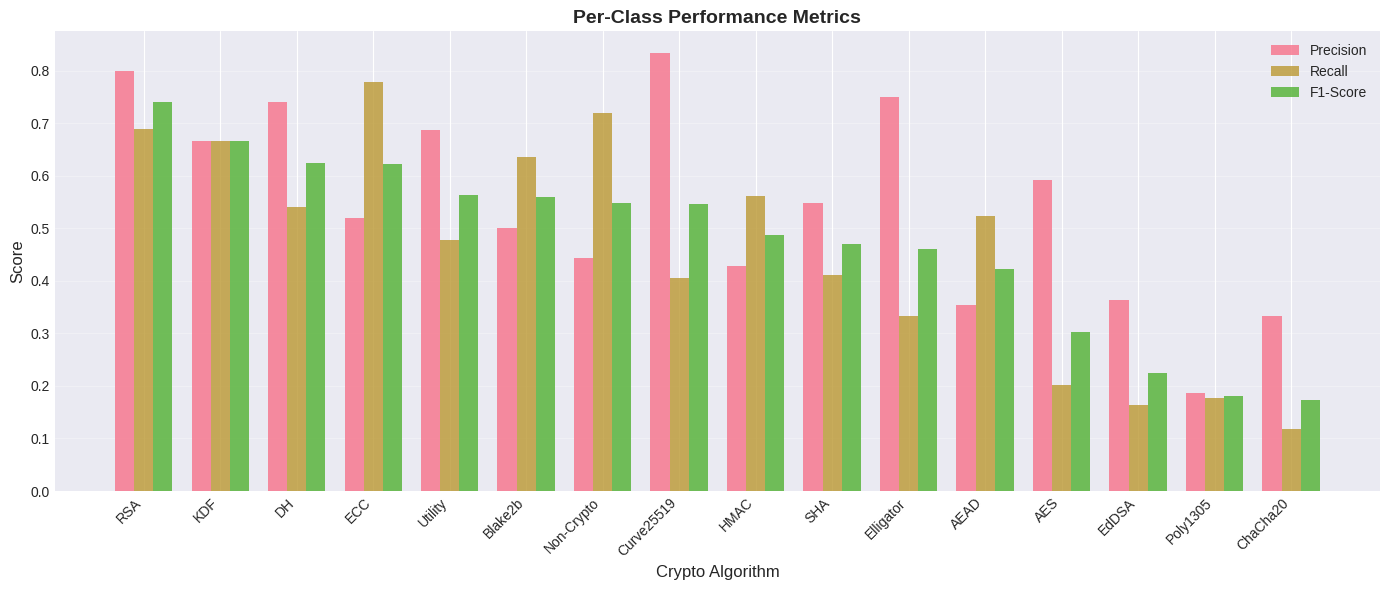

In [19]:
# Detailed per-class metrics
precision, recall, f1, support = precision_recall_fscore_support(
    test_results['labels'],
    test_results['predictions'],
    labels=range(num_classes)
)

performance_df = pd.DataFrame({
    'Class': train_dataset.label_encoder.classes_,
    'Precision': precision,
    'Recall': recall,
    'F1-Score': f1,
    'Support': support
}).sort_values('F1-Score', ascending=False)

print("\nPer-class performance:")
print(performance_df.to_string(index=False))

# Visualize
fig, ax = plt.subplots(figsize=(14, 6))
x = np.arange(len(performance_df))
width = 0.25

ax.bar(x - width, performance_df['Precision'], width, label='Precision', alpha=0.8)
ax.bar(x, performance_df['Recall'], width, label='Recall', alpha=0.8)
ax.bar(x + width, performance_df['F1-Score'], width, label='F1-Score', alpha=0.8)

ax.set_xlabel('Crypto Algorithm', fontsize=12)
ax.set_ylabel('Score', fontsize=12)
ax.set_title('Per-Class Performance Metrics', fontweight='bold', fontsize=14)
ax.set_xticks(x)
ax.set_xticklabels(performance_df['Class'], rotation=45, ha='right')
ax.legend()
ax.grid(axis='y', alpha=0.3)
plt.tight_layout()
plt.savefig(os.path.join(CONFIG['output_dir'], 'per_class_performance.png'), dpi=300, bbox_inches='tight')
plt.show()

---
## Part 8: Save Model for Inference

In [20]:
# Save metadata for inference pipeline
metadata = {
    'label_encoder': train_dataset.label_encoder,
    'node_scaler': train_dataset.node_scaler,
    'edge_scaler': train_dataset.edge_scaler,
    'graph_scaler': train_dataset.graph_scaler,
    'model_config': {
        'num_node_features': num_node_features,
        'num_edge_features': num_edge_features,
        'num_graph_features': num_graph_features,
        'num_classes': num_classes,
        'hidden_dim': CONFIG['hidden_dim'],
        'num_layers': CONFIG['num_layers'],
        'dropout': CONFIG['dropout'],
        'conv_type': CONFIG['conv_type'],
        'pooling': CONFIG['pooling'],
    }
}

metadata_path = os.path.join(CONFIG['model_dir'], 'metadata.pkl')
with open(metadata_path, 'wb') as f:
    pickle.dump(metadata, f)

print(f"✓ Metadata saved to: {metadata_path}")
print(f"✓ Model saved to: {os.path.join(CONFIG['model_dir'], 'best_model.pth')}")
print("\nYou can now use these for inference on new binaries!")

✓ Metadata saved to: ./gnn_models/metadata.pkl
✓ Model saved to: ./gnn_models/best_model.pth

You can now use these for inference on new binaries!


---
## Part 9: Inference Demo

Run inference on a sample file.

In [21]:
# Import inference pipeline
from new_gnn import CryptoDetectionPipeline

# Create pipeline
pipeline = CryptoDetectionPipeline(
    model_path=os.path.join(CONFIG['model_dir'], 'best_model.pth'),
    metadata_path=metadata_path
)

print("✓ Inference pipeline created")

✓ Loaded model from ./gnn_models/best_model.pth
✓ Model trained on 16 classes
✓ Inference pipeline created


In [22]:
# Run inference on a test file
if test_files:
    demo_file = test_files[0]
    output_path = os.path.join(CONFIG['output_dir'], 'detection_results.json')
    
    print(f"Running inference on: {os.path.basename(demo_file)}")
    results = pipeline.process_json(demo_file, output_path)
    
    # Display top detections
    if results['crypto_functions']:
        print("\n" + "="*60)
        print("TOP 5 CRYPTO DETECTIONS")
        print("="*60)
        for i, func in enumerate(results['crypto_functions'][:5], 1):
            print(f"\n{i}. Address: {func['address']}")
            print(f"   Name: {func['name']}")
            print(f"   Algorithm: {func['algorithm']}")
            print(f"   Confidence: {func['confidence']:.4f}")
            print(f"   Top 3 probabilities:")
            sorted_probs = sorted(func['probabilities'].items(), key=lambda x: x[1], reverse=True)[:3]
            for algo, prob in sorted_probs:
                print(f"     {algo}: {prob:.4f}")
else:
    print("No test files available for inference demo")

Running inference on: wolfssl_aes_x86_O3.o_features.json

Processing: /home/bhoomi/Desktop/compilerRepo/vestigo-data/ghidra_json/wolfssl_aes_x86_O3.o_features.json


Detecting crypto:   0%|          | 0/14 [00:00<?, ?it/s]

Loading 0 JSON files...


Loading data: 0it [00:00, ?it/s]



Dataset loaded: 0 functions
Label distribution:
Loading 0 JSON files...


Loading data: 0it [00:00, ?it/s]



Dataset loaded: 0 functions
Label distribution:
Loading 0 JSON files...


Loading data: 0it [00:00, ?it/s]



Dataset loaded: 0 functions
Label distribution:
Loading 0 JSON files...


Loading data: 0it [00:00, ?it/s]



Dataset loaded: 0 functions
Label distribution:
Loading 0 JSON files...


Loading data: 0it [00:00, ?it/s]



Dataset loaded: 0 functions
Label distribution:
Loading 0 JSON files...


Loading data: 0it [00:00, ?it/s]



Dataset loaded: 0 functions
Label distribution:
Loading 0 JSON files...


Loading data: 0it [00:00, ?it/s]



Dataset loaded: 0 functions
Label distribution:
Loading 0 JSON files...


Loading data: 0it [00:00, ?it/s]



Dataset loaded: 0 functions
Label distribution:
Loading 0 JSON files...


Loading data: 0it [00:00, ?it/s]
Detecting crypto:  64%|██████▍   | 9/14 [00:00<00:00, 86.82it/s]


Dataset loaded: 0 functions
Label distribution:
Loading 0 JSON files...


Loading data: 0it [00:00, ?it/s]



Dataset loaded: 0 functions
Label distribution:
Loading 0 JSON files...


Loading data: 0it [00:00, ?it/s]



Dataset loaded: 0 functions
Label distribution:
Loading 0 JSON files...


Loading data: 0it [00:00, ?it/s]



Dataset loaded: 0 functions
Label distribution:
Loading 0 JSON files...


Loading data: 0it [00:00, ?it/s]


Dataset loaded: 0 functions
Label distribution:


Loading 0 JSON files...


Loading data: 0it [00:00, ?it/s]
Detecting crypto: 100%|██████████| 14/14 [00:00<00:00, 97.02it/s]


Dataset loaded: 0 functions
Label distribution:

✓ Saved results to: ./gnn_outputs/detection_results.json

CRYPTO DETECTION SUMMARY
Total functions analyzed: 14
Crypto functions detected: 13
Non-crypto functions: 1

Detected algorithms:
  ECC: 8
  SHA: 3
  AES: 2

Top 5 crypto functions by confidence:
  1. 00014360 (wc_AesGetKeySize)
     Algorithm: ECC (confidence: 0.9947)
  2. 00014280 (wc_AesInit)
     Algorithm: ECC (confidence: 0.9759)
  3. 00010d80 (AesSetKey_C)
     Algorithm: AES (confidence: 0.9733)
  4. 000142c0 (wc_AesFree)
     Algorithm: ECC (confidence: 0.9606)
  5. 00011da0 (wc_AesCbcEncrypt)
     Algorithm: ECC (confidence: 0.8981)

TOP 5 CRYPTO DETECTIONS

1. Address: 00014360
   Name: wc_AesGetKeySize
   Algorithm: ECC
   Confidence: 0.9947
   Top 3 probabilities:
     ECC: 0.9947
     AES: 0.0037
     Non-Crypto: 0.0010

2. Address: 00014280
   Name: wc_AesInit
   Algorithm: ECC
   Confidence: 0.9759
   Top 3 probabilities:
     ECC: 0.9759
     AES: 0.0104
     SHA

---
## Summary

This notebook demonstrated:

✅ **Address-aware feature extraction** - Novel spatial features  
✅ **Data loading** - Ghidra JSON → PyTorch Geometric graphs  
✅ **GNN training** - Multiple architectures (GCN, GAT, SAGE, GIN)  
✅ **Evaluation** - Comprehensive metrics and visualizations  
✅ **Inference** - Production-ready detection pipeline  

### Next Steps

1. **Hyperparameter tuning**: Run `gnn_hyperparameter_tuning.py`
2. **Try different architectures**: Change `conv_type` to 'gcn', 'sage', or 'gin'
3. **Increase epochs**: Set `num_epochs` to 100+ for better performance
4. **Deploy**: Use the inference pipeline on new binaries

### Files Generated

- `gnn_models/best_model.pth` - Trained model weights
- `gnn_models/metadata.pkl` - Scalers and label encoder
- `gnn_outputs/training_history.png` - Learning curves
- `gnn_outputs/confusion_matrix.png` - Performance matrix
- `gnn_outputs/per_class_performance.png` - Per-class metrics
- `gnn_outputs/detection_results.json` - Inference results

**Ready to detect crypto! 🔐🔍**